In [1]:
import cv2
import pyxdf
import pandas as pd
from utils import *
import matplotlib.pyplot as plt

In [2]:
xdf_filename = '/Users/bryan.gonzalez/CUNY_subs/sub-P5029423/sub-P5029423_ses-S001_task-CUNY_run-001_mobi.xdf'
cam_df = import_webcam_data(xdf_filename)
stim_df = import_stim_data(xdf_filename)
vid_path = '/Users/bryan.gonzalez/CUNY_subs/sub-P5029423/sub-P5029423_task-CUNY_run-001_video.avi'


# Duration Check

In [ ]:
exp_start = stim_df.loc[stim_df.event == 'Onset_Experiment', 'lsl_time_stamp'].values[0]
exp_end = stim_df.loc[stim_df.event == 'Offset_Experiment', 'lsl_time_stamp'].values[0]
experiment_dur = exp_end - exp_start

cam_exp = get_event_data('Experiment', cam_df, stim_df=stim_df)
start = cam_exp['lsl_time_stamp'].values[0]
stop = cam_exp['lsl_time_stamp'].values[-1]
cam_dur = stop - start

if abs(experiment_dur - cam_dur) < 0.1:
    print('Experiment duration matches camera duration!')

    print('Experiment: ', experiment_dur)
    print('Webcam Stream: ', cam_dur)
else:
    print('Experiment duration does not match camera duration!')
    print('Experiment: ', experiment_dur)
    print('Webcam Stream: ', cam_dur)


Experiment duration matches camera duration!
Experiment:  2211.697342959
Webcame Stream:  2211.672251743177


# Sampling rate

In [13]:
1/cam_df.frame_time_sec.diff().mean()  # 30 fps

np.float64(30.040601306370288)

# Video File

In [ ]:
cam_df['face_detected'] = False

In [64]:

vid_frames = get_event_data('SocialTask', df=cam_df, stim_df=stim_df)['frame_num'].values
vid_frames

array([57334, 57335, 57336, ..., 66339, 66340, 66341], shape=(9008,))

In [65]:

def count_faces_in_video(video_path, frame_skip=10, foi=vid_frames):
    """Counts the number of frames with detected faces using a deep learning-based face detector,
    and returns the indices of the frames where faces are detected."""
    
    # Load the pre-trained MobileNet SSD model and config file for face detection
    net = cv2.dnn.readNetFromCaffe(
        '/Users/bryan.gonzalez/MOBI_QC/src/MOBI_QC/deploy.prototxt',  # Path to the model configuration file
        '/Users/bryan.gonzalez/MOBI_QC/src/MOBI_QC/res10_300x300_ssd_iter_140000_fp16.caffemodel'  # Path to the model weights
    )

    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return 0, []

    face_count = 0
    frame_idx = 0
    frames_with_faces = []
    frames_checked = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Skip frames for efficiency
        if frame_idx % frame_skip == 0:
            # Check if the current frame index is in the list of frames of interest
            if frame_idx in foi:
                frames_checked.append(frame_idx)
                # Prepare the frame for the DNN model (resize to 300x300 and normalize)
                blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0), swapRB=True, crop=False)
                net.setInput(blob)

                # Perform face detection
                detections = net.forward()

                # Check if a face is detected
                for i in range(detections.shape[2]):
                    confidence = detections[0, 0, i, 2]
                    if confidence > 0.5:  # Confidence threshold
                        face_count += 1
                        frames_with_faces.append(frame_idx)  # Save the frame index where a face is detected
                        break  # Count one face per frame

        frame_idx += 1  # Increment frame counter

    cap.release()
    return face_count, frames_with_faces, frames_checked

In [74]:
fc, face_frames, frames_checked = count_faces_in_video(vid_path, frame_skip=10, foi=vid_frames)
frames_without_faces = [frame for frame in frames_checked if frame not in face_frames]


In [67]:
fc/len(frames_checked)

0.9778024417314095

Text(0.5, 1.0, 'Frame without a face detected')

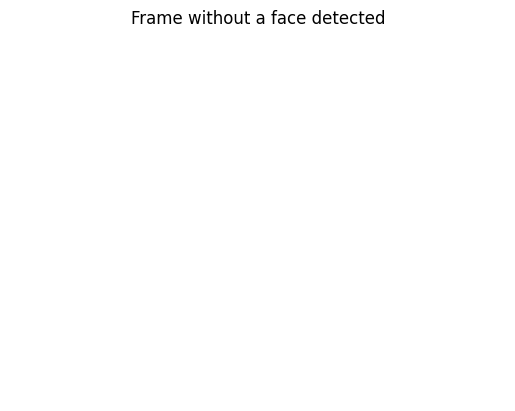

In [77]:
# PLOT A SINGLE FRAME OF THE VIDEO
cap = cv2.VideoCapture(vid_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frames_without_faces[np.random.randint(0, len(frames_without_faces))]) 
ret, frame = cap.read()
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Frame without a face detected')
#plt.show()

With a new line

In [71]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def extract_frames(video_path, frame_indices, resize_scale=0.5):
    """Extracts specific frames from a video and returns them as a list of images."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return []

    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)  # Move to specific frame
        success, frame = cap.read()
        if not success:
            print(f"Warning: Could not read frame {frame_idx}")
            continue
        
        # Convert BGR to RGB (OpenCV loads images in BGR format)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Resize frame if needed
        if resize_scale != 1.0:
            frame = cv2.resize(frame, (0, 0), fx=resize_scale, fy=resize_scale, interpolation=cv2.INTER_LANCZOS4)

        frames.append(frame)

    cap.release()
    return frames

def plot_frames_with_wrap(frames, highlight_indices=[], overlap_ratio=0.3, frames_per_row=20):
    """Plots frames with 30% overlap, wrapping to a new row every `frames_per_row` frames."""
    if not frames:
        print("No frames to display.")
        return
    
    frame_width = frames[0].shape[1]
    frame_height = frames[0].shape[0]

    overlap_pixels = int(frame_width * overlap_ratio)  # Amount of overlap in pixels
    num_rows = int(np.ceil(len(frames) / frames_per_row))  # Determine number of rows

    # Compute canvas size
    row_width = frame_width + (frames_per_row - 1) * (frame_width - overlap_pixels)  # Width for each row
    total_height = num_rows * frame_height  # Stack rows vertically

    canvas = np.ones((total_height, row_width, 3), dtype=np.uint8) * 255  # White background

    for i, frame in enumerate(frames):
        row = i // frames_per_row  # Determine which row the frame belongs to
        col = i % frames_per_row   # Determine position in the row

        x_start = col * (frame_width - overlap_pixels)  # X position
        y_start = row * frame_height  # Y position (new row starts here)

        # If frame should be highlighted, make it red
        if i in highlight_indices:
            red_frame = frame.copy()
            red_frame[:, :, 1:] = 0  # Set green and blue channels to 0, keeping only red
            frame = red_frame

        # Apply random noise to the frame
        noise = np.random.normal(0, 1, frame.shape).astype(np.uint8)
        #frame = cv2.add(frame, noise)
        # Overlay the frame
        canvas[y_start:y_start + frame_height, x_start:x_start + frame_width] = frame

    # Plot the final stitched image
    plt.figure(figsize=(frames_per_row * 1.5, num_rows * 2.5))  # Adjust figure size dynamically
    plt.imshow(canvas)
    plt.axis("off")
    plt.show()


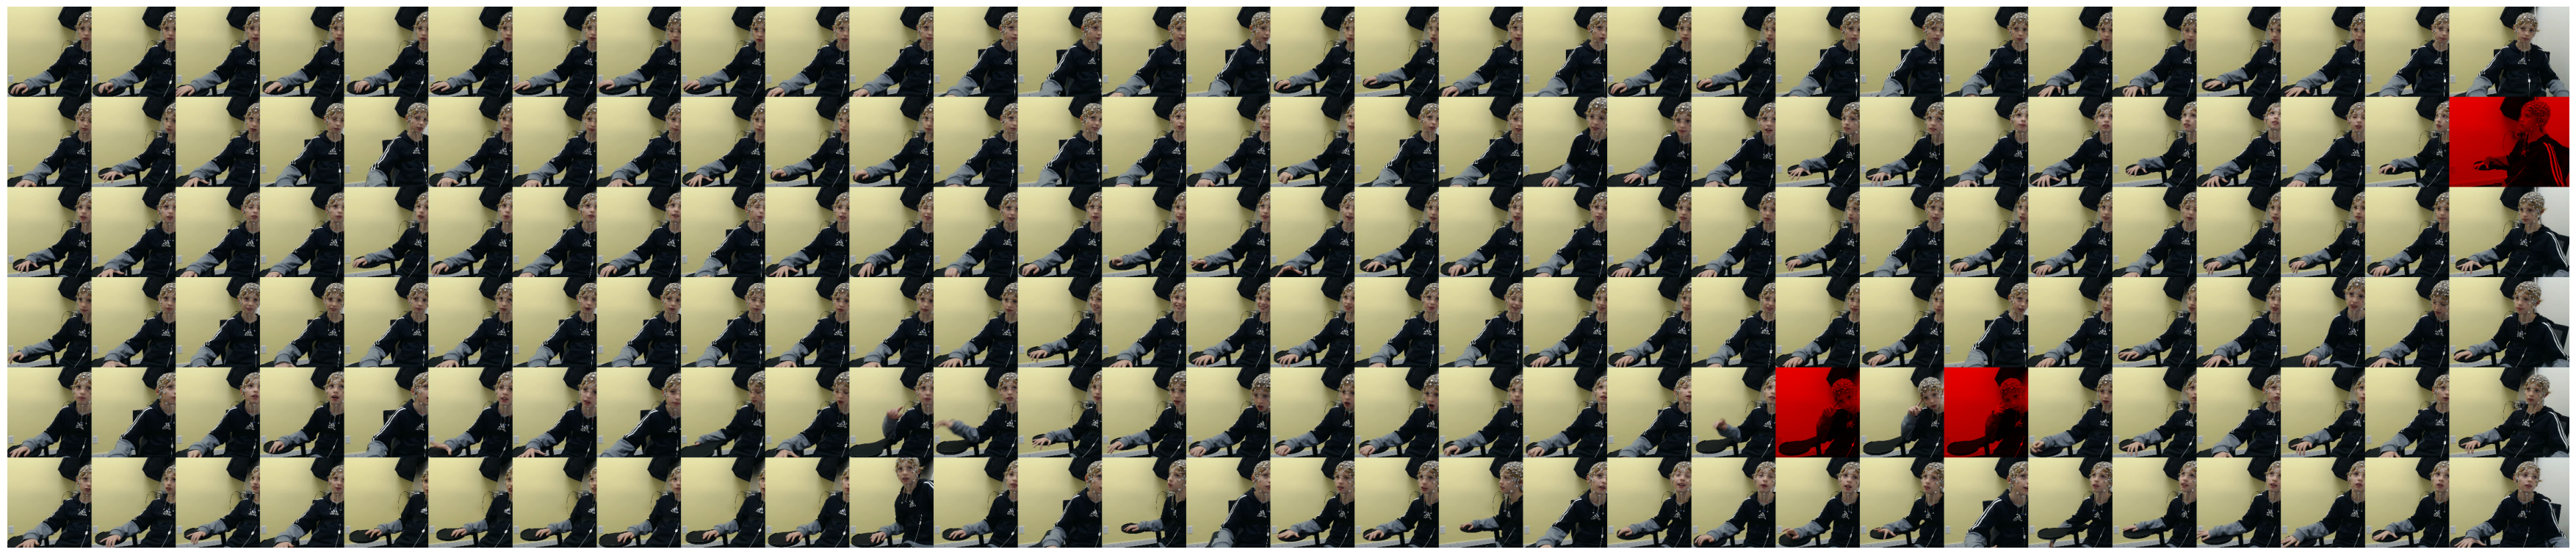

In [72]:

# Example usage
video_path = "your_video.avi"  # Replace with your video path
frame_indices = frames_checked[5::5]#np.linspace(0, len(frames_checked), 200, dtype=int)  # Extract 50 frames across the video
#highlight_indices = [10, 25, 40, 80, 89, 90, 200, 201, 202]  # Indices of frames to be highlighted in red
highlight_indices = [frame_indices.index(xx)  for xx in [x for x in frames_without_faces if x in frame_indices]]
frames = extract_frames(vid_path, frame_indices, resize_scale=0.35)
plot_frames_with_wrap(frames, highlight_indices=highlight_indices, overlap_ratio=0.3, frames_per_row=30)


In [16]:
frame_indices

[200,
 400,
 600,
 800,
 1000,
 1200,
 1400,
 1600,
 1800,
 2000,
 2200,
 2400,
 2600,
 2800,
 3000,
 3200,
 3400,
 3600,
 3800,
 4000,
 4200,
 4400,
 4600,
 4800,
 5000,
 5200,
 5400,
 5600,
 5800,
 6000,
 6200,
 6400,
 6600,
 6800,
 7000,
 7200,
 7400,
 7600,
 7800,
 8000,
 8200,
 8400,
 8600,
 8800,
 9000,
 9200,
 9400,
 9600,
 9800,
 10000,
 10200,
 10400,
 10600,
 10800,
 11000,
 11200,
 11400,
 11600,
 11800,
 12000,
 12200,
 12400,
 12600,
 12800,
 13000,
 13200,
 13400,
 13600,
 13800,
 14000,
 14200,
 14400,
 14600,
 14800,
 15000,
 15200,
 15400,
 15600,
 15800,
 16000,
 16200,
 16400,
 16600,
 16800,
 17000,
 17200,
 17400,
 17600,
 17800,
 18000,
 18200,
 18400,
 18600,
 18800,
 19000,
 19200,
 19400,
 19600,
 19800,
 20000,
 20200,
 20400,
 20600,
 20800,
 21000,
 21200,
 21400,
 21600,
 21800,
 22000,
 22200,
 22400,
 22600,
 22800,
 23000,
 23200,
 23400,
 23600,
 23800,
 24000,
 24200,
 24400,
 24600,
 24800,
 25000,
 25200,
 25400,
 25600,
 25800,
 26000,
 26200,
 2640

[54400]

[271]